In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action="ignore")

In [2]:
RANDOM_STATE = 1
COLUMN_FOR_CLASSIFICATION = "tfopwg_disp"
CORRELATION_THRESHOLD = 0.9
TEST_SIZE = 0.4

In [3]:
df = pd.read_csv("./TOI_2025.09.30_18.37.25.csv")
df.tail()

,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
7694,7695,995.01,995,317951248,3.179512e+08,1,FP,07h23m14.75s,110.811443,NaN,...,NaN,0,1,NaN,NaN,NaN,0,1,2019-07-24 15:58:33,2021-10-29 12:59:15
7695,7696,996.01,996,142918609,1.429186e+08,1,FP,07h57m23.99s,119.349948,NaN,...,NaN,0,1,2.050000,NaN,NaN,0,1,2019-07-24 15:58:33,2021-10-29 12:59:15
7696,7697,997.01,997,341729521,3.417295e+08,1,FP,08h05m16.69s,121.319521,NaN,...,-0.08,0,1,0.926261,0.045789,-0.045789,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
7697,7698,998.01,998,54390047,5.439005e+07,1,FP,07h53m16.69s,118.319555,NaN,...,-0.07,0,1,2.349860,0.091578,-0.091578,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
7698,7699,999.01,999,341186896,3.411869e+08,1,FP,07h55m27.38s,118.864086,NaN,...,-0.09,0,1,1.300000,0.050000,-0.050000,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7699 entries, 0 to 7698
Data columns (total 87 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              7699 non-null   int64  
 1   toi                7699 non-null   float64
 2   toipfx             7699 non-null   int64  
 3   tid                7699 non-null   int64  
 4   ctoi_alias         7699 non-null   float64
 5   pl_pnum            7699 non-null   int64  
 6   tfopwg_disp        7699 non-null   object 
 7   rastr              7699 non-null   object 
 8   ra                 7699 non-null   float64
 9   raerr1             0 non-null      float64
 10  raerr2             0 non-null      float64
 11  decstr             7699 non-null   object 
 12  dec                7699 non-null   float64
 13  decerr1            0 non-null      float64
 14  decerr2            0 non-null      float64
 15  st_pmra            7565 non-null   float64
 16  st_pmraerr1        7565 

In [5]:
df = df[~df[COLUMN_FOR_CLASSIFICATION].isin(["FA", "CP"])]
df[COLUMN_FOR_CLASSIFICATION] = (
    df[COLUMN_FOR_CLASSIFICATION].astype("category").cat.codes
)
df[COLUMN_FOR_CLASSIFICATION].value_counts()

tfopwg_disp
3    4678
1    1196
2     583
0     461
Name: count, dtype: int64

In [6]:
# Remove all string columns
df = df.select_dtypes(include=[np.number])

# Remove all columns with null values
df = df.dropna(axis=1)

# Remove identifier columns
df = df.drop(
    columns=["rowid", "pl_pnum", *list(df.filter(regex="err$|lim$", axis=1).columns)],
    axis=1,
)

In [7]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
to_drop = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > CORRELATION_THRESHOLD)
]
df.drop(to_drop, axis=1, inplace=True)

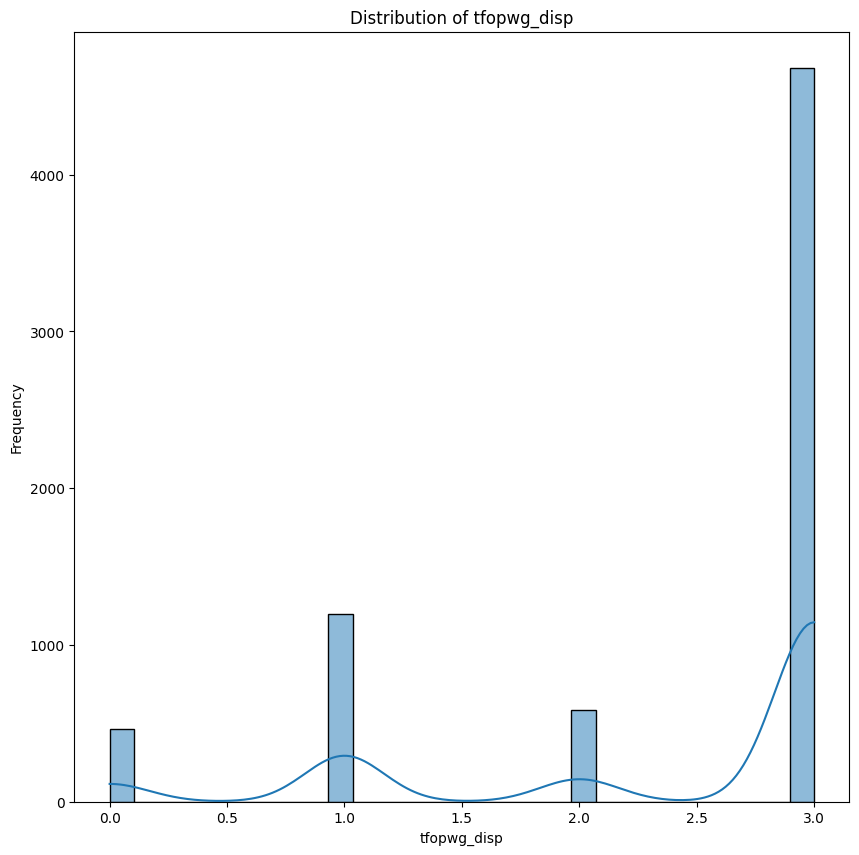

In [8]:
def plot_distribution(df: pd.DataFrame, col: str):
    plt.figure(figsize=(10, 10))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


plot_distribution(df, COLUMN_FOR_CLASSIFICATION)

<Axes: >

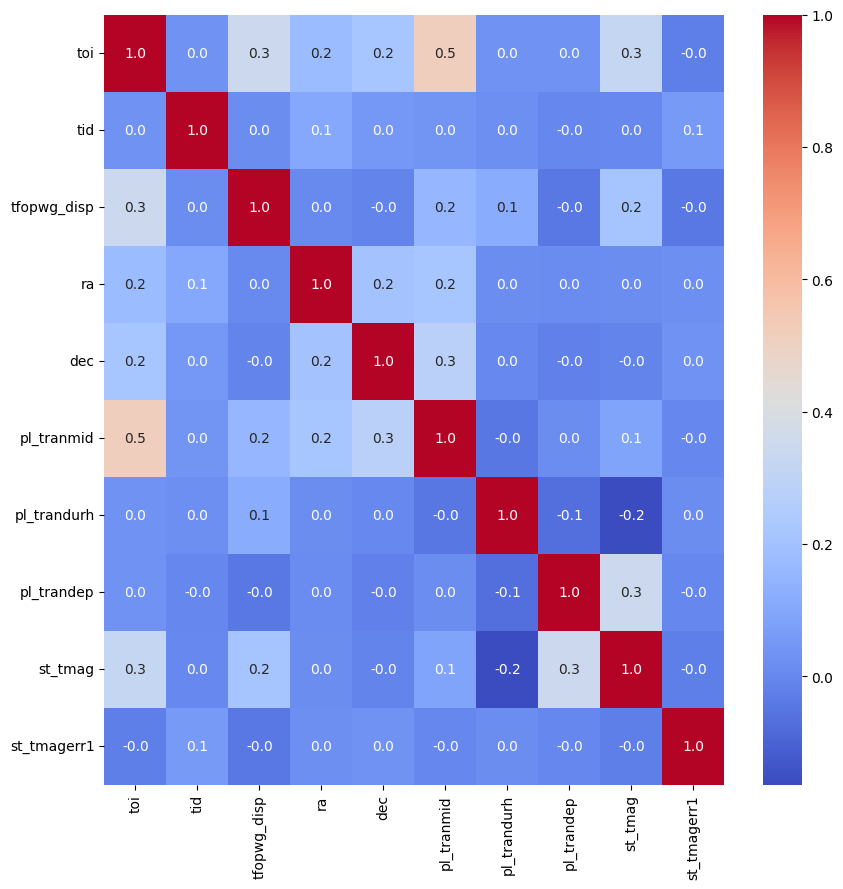

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".1f")

In [10]:
# Check if there are missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [11]:
y = df[COLUMN_FOR_CLASSIFICATION]
X = df.drop(columns=[COLUMN_FOR_CLASSIFICATION], axis=1)

In [12]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
X = pd.DataFrame(imputer.transform(X))

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features)

In [13]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)

print(f"Training accuracy: {rf_clf.score(X_train, y_train) * 100:3.2f}%")
print(f"Testing accuracy: {rf_clf.score(X_test, y_test) * 100:3.2f}%")

Training accuracy: 100.00%
Testing accuracy: 74.60%


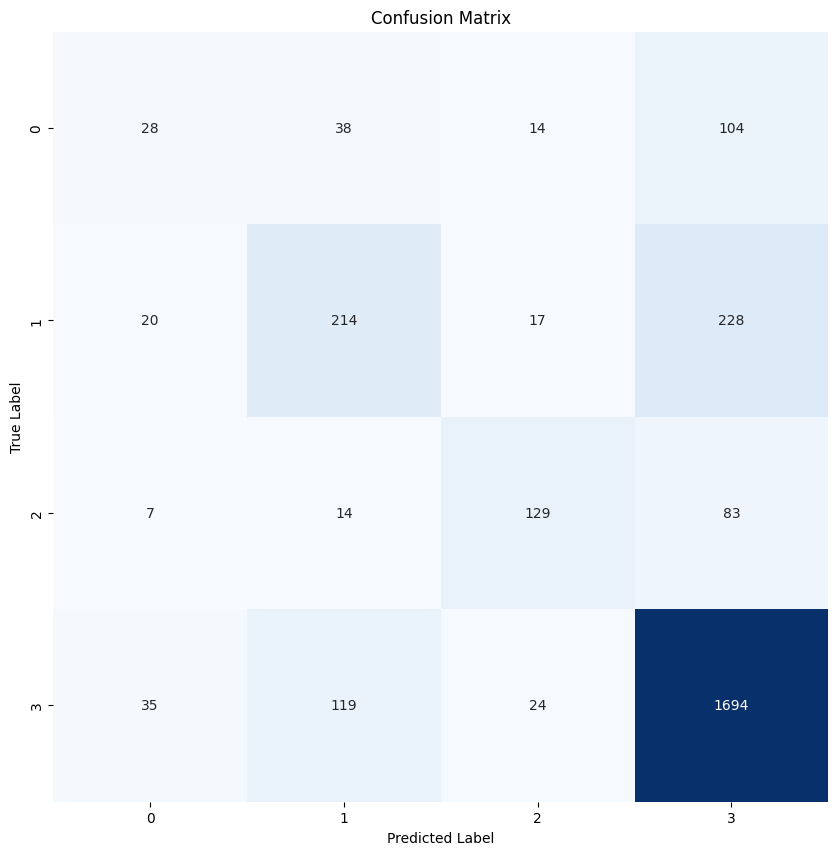

In [15]:
cf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

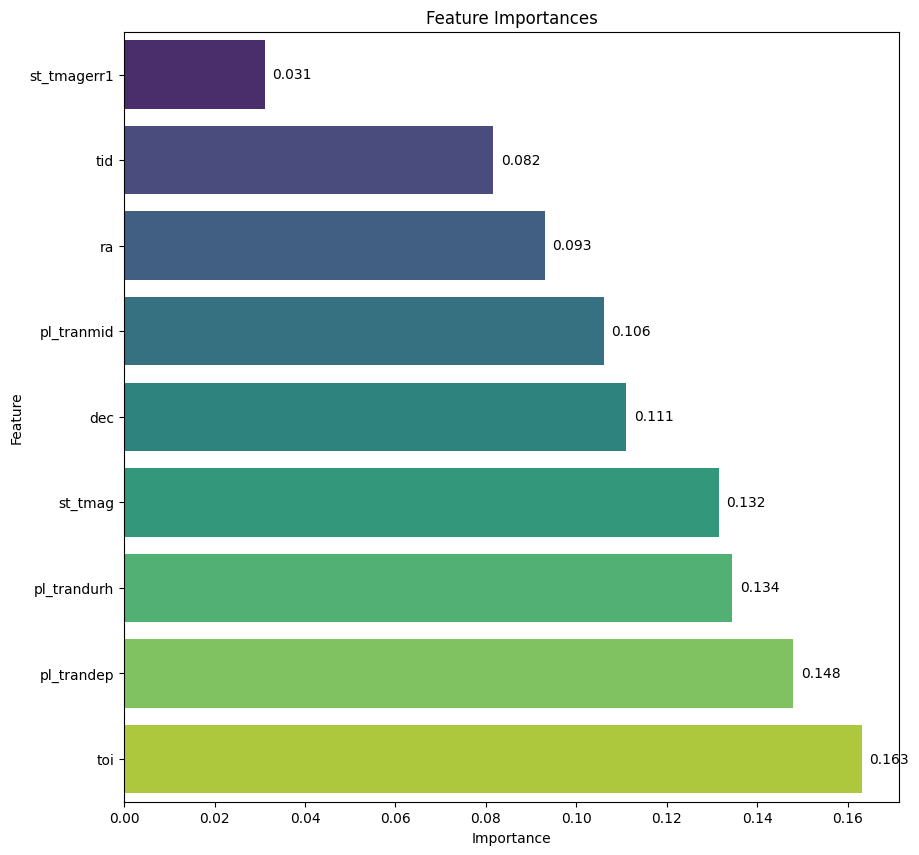

In [16]:
feature_names = df.drop(columns=[COLUMN_FOR_CLASSIFICATION]).columns.tolist()
importances = rf_clf.feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=feat_series.values, y=feat_series.index, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
for i, v in enumerate(feat_series.values):
    ax.text(v + max(feat_series.values) * 0.01, i, f"{v:.3f}", va="center")

plt.show()